In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
from matplotlib.colors import LogNorm, Normalize
from scipy.signal import butter, lfilter, freqz,detrend
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy import constants
#sns.set_theme()
import re
import utils
from scipy import ndimage
from scipy.signal import lfilter
from scipy.ndimage.filters import gaussian_filter
import cv2

In [241]:
#Record_2022-09-27_14-14-14.bin
no_reflector = "felttest1/Record_2022-09-27_14-34-48/Record_2022-09-27_14-34-48.bin"
best_restult = "felttest1/Record_2022-09-27_14-14-14/Record_2022-09-27_14-14-14.bin"
munkholm = "felttest2/Record_2022-09-28_15-13-15/Record_2022-09-28_15-13-15.bin"
try:
    #with open("felttest2/Record_2022-09-28_14-48-46/Record_2022-09-28_14-48-46.bin", "rb") as f:
    #with open("Record_2022-09-28_15-13-15.bin", "rb") as f:
    with open(best_restult, "rb") as f:

        data = f.read()
    
        
        
except IOError as e:
    print(e)

In [243]:
stri = "DONE"
done = False
data_arr = []
index = 0
data_bytes = data
while(not done):
    ls = re.search(stri.encode(), data_bytes).end()
    data_arr.append(data_bytes[:ls])
    data_bytes = data_bytes[ls+4:]
    print(len(data_bytes))
    if(len(data_bytes) == 0):
        done = True

725850672
724801916
723753136
722704392
721655612
720606868
719558112
718509392
717460660
716411904
715363148
714314380
713265588
712216796
711168028
710119236
709070456
708021664
706972884
705924116
704875336
703826556
702777764
701728996
700680192
699631364
698582548
697533708
696484880
695436064
694387248
693338480
692289712
691240944
690192152
689143360
688094604
687045860
685997104
684948312
683899532
682850776
681802008
680753264
679704520
678655776
677606960
676558156
675509412
674460620
673411828
672363072
671314304
670265548
669216780
668168012
667119232
666070428
665021624
663972784
662923992
661875224
660826396
659777604
658728824
657680056
656631300
655582532
654533752
653484972
652436204
651387424
650338680
649289924
648241156
647192424
646143668
645094900
644046132
642997328
641948536
640899756
639850940
638802148
637753368
636704552
635655748
634606992
633558212
632509384
631460580
630411788
629362984
628314180
627265352
626216560
625167780
624118940
623070116
622021256


In [37]:
def simple_exp_smooth(d,extra_periods=1,alpha=0.4):  
  #d = np.array(d)  # Transform the input into a numpy array  
  cols = len(d)  # Historical period length  
  #d = np.append(d,[np.nan]*extra_periods)  # Append np.nan into the demand array to cover future periods  
  f = np.zeros_like(d)  # Forecast array  
  f[0] = d[0]  # initialization of first forecast  
 
  # Create all the t+1 forecasts until end of historical period  
  for t in range(1,cols):  
    f[t] = alpha*d[t]+(1-alpha)*f[t-1]
  #print(f)  
  f[cols+1:] = f[t]  # Forecast for all extra periods  
  #df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f})
  return f,d

In [38]:
c = constants.c
sample_bandwidth  = 191.0153846e6
sample_frek = 2*sample_bandwidth # sample frekuenzy
frame_rate =50*10**(-3) # frame rate
sample_per_frame = 260*257 # sample pr frame
c_t = (1/sample_bandwidth )*256 # sample period
#fs_new = 1/sample_period_new # sample frekuenzy 

In [231]:
def background_update(frames, alpha=1/128, nr_of_ma=1,window=1):
    fft_length = 256
    MRDM =np.zeros((len(frames),fft_length,fft_length),dtype=np.complex_)
    
        
    for i,frame in enumerate(frames):
                length = int.from_bytes(
                        frame[4:8], byteorder="little", signed=False)
                
                data_RADC = frame[8:8+length]
                data_RADC = np.frombuffer(data_RADC,dtype=np.uint16)
                data_RADC = data_RADC.reshape(3,256,512)
                data_RADC_I_raw = data_RADC[:,:,::2]
                data_RADC_Q_raw = data_RADC[:,:,1::2]
                data_RADC_I = detrend(data_RADC_I_raw, axis=2)
                data_RADC_Q = detrend(data_RADC_Q_raw, axis=2)
                #window = signal.windows.chebwin(256, 100, sym=True)#signal.windows.hann(256)
                #data_RADC_I_mean = np.mean(data_RADC_I, axis=0)
                #data_RADC_Q_mean = np.mean(data_RADC_Q, axis=0)
                data_RADC_I_mean = data_RADC_I[0]
                data_RADC_Q_mean = data_RADC_Q[0]
                data_IF = window*data_RADC_I_mean[:,:] + window*1j*data_RADC_Q_mean[:,:]
            

                data_range_baseline =utils.fft_and_plot(data_IF, axis=1, fs=sample_frek,fft_size=fft_length,plot=False,shift =False)
                #data_range_baseline = utils.MIT_filter( data_range_baseline)
                for j in range(fft_length):
                    data_range_baseline[:,j] = window*data_range_baseline[:,j]
                #
                data_range_baseline = utils.MIT_filter( data_range_baseline)
                data_doppler_window_slow= utils.fft_and_plot(data_range_baseline, axis=0,fft_size=fft_length,shift =True)
                
                #MRDM[i]=cv2.GaussianBlur(np.abs(data_doppler_window_slow) ,(3, 3),sigmaX=1,sigmaY=1)
            
                MRDM[i] = data_doppler_window_slow

    #MIT
   
    #MRDM = np.mean(MRDM,axis=0)
    
    raw_frames = MRDM.copy()
    data_procesed =MRDM.copy()
  
    data_diff = MRDM.copy()
    for i in range(nr_of_ma):
            MA,frames =simple_exp_smooth(np.abs(data_diff.copy()),alpha =alpha)
            data_diff = np.abs(frames) -np.abs(MA)
            
            #ata_diff =gaussian_filter(data_diff, sigma=1,mode='constant')
            print("MA",i)
     #   data_procesed[k] = data_diff
    #data_diff = np.mean(data_procesed,axis=0)
    utils.CFAR_2D(data_diff[-1].copy(),10, 15, 0.000001,plot=False, iso_axis=True)
    return MRDM,raw_frames,data_diff

In [244]:
idx = 301
data_ma,raw_t,data_diff = background_update(data_arr[1:-1],nr_of_ma=
3, alpha=1/256,window=1)

MA 0
MA 1
MA 2
traning area 2160


In [80]:
plot_min_range = 40
plot_max_range = 120
plot_min_doppler = 100
plot_max_doppler = 150
plot_min_3d = 80
plot_max_3d = 95

# Remove peaks


In [81]:
#remove peaks
noise = np.mean(data_diff[1,200:220,50:70])
for i,d in enumerate(data_diff):
    data_diff[i,90:94,204:207] = noise
    data_diff[i,163:170,50:54] = noise

(256, 256)


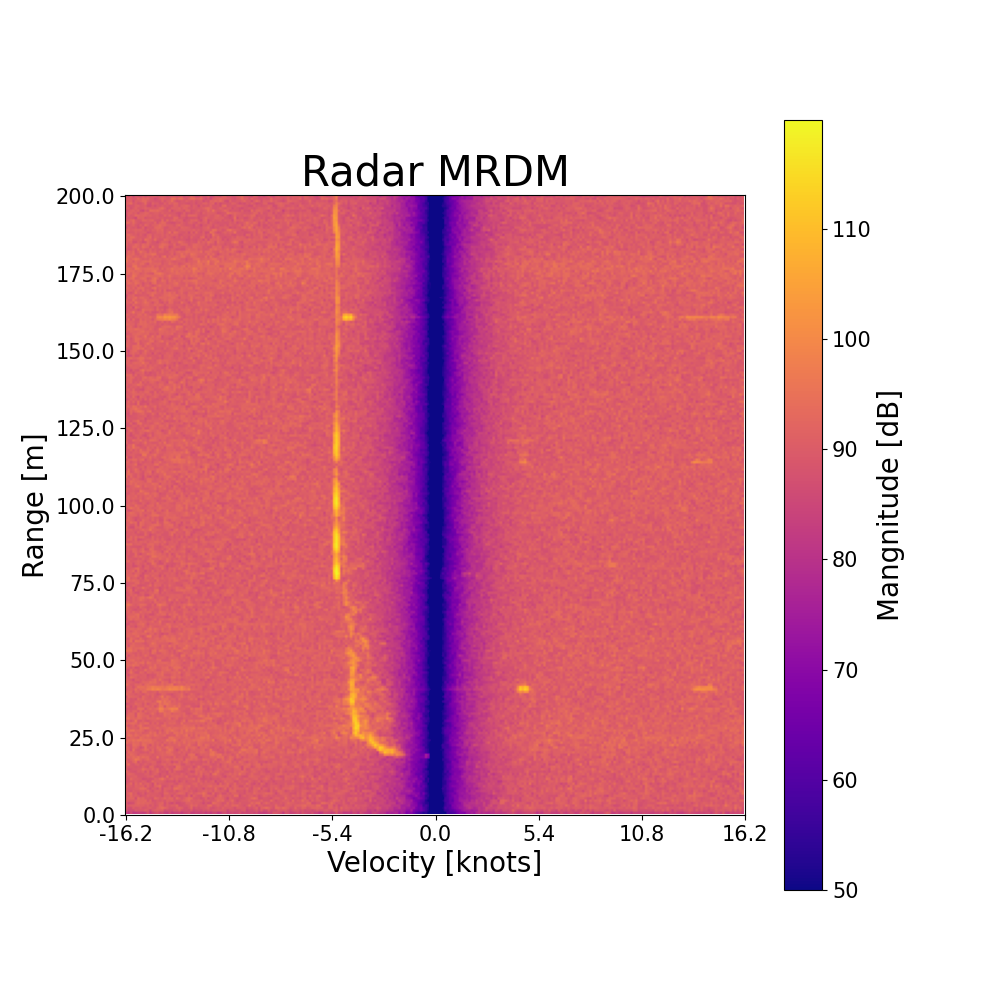

In [220]:
#%matplotlib ipympl
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "Radar MRDM"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})

test = np.max(np.abs(data_diff[:500]),axis=0)
plt.figure(figsize=(10,10))
print(np.shape(test))
#test[test>40] =0
rotated_img = ndimage.rotate(test,90)
#rotated_img = np.flip(test,axis=0)
rotated_img =20*np.log10(np.abs(rotated_img)) # We rotate the image so the x axis is the velocity


#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
#plt.imshow(rotated_img,cmap="plasma", vmin=plot_min_doppler,vmax=plot_max_doppler)
plt.imshow(rotated_img,cmap="plasma",vmin =50)
# rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
# peak = 10*np.log(np.abs(rotated_img[137,87]))
# snr = peak-rms
# print("Peak:",peak)
# print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
# print("RMS:",rms)
# print("SNR:",snr) 
#plt.xlim(80,94)
plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)



plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)
#plt.savefig("plots/munkholm/cfar_EMA_0_MTI_munkholm_with_window.svg",format="svg")

In [255]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

#fig=plt.figure()
#ax1=fig.add_subplot(1,1,1)

def animate(i):
    rotated_img = ndimage.rotate(data_diff[i],90)
    ax1.imshow(rotated_img,cmap="plasma", vmin=0,vmax=300000)
    ax1.set_title(f"Frame: {i}")
    ax1.set_xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
    ax1.set_yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
    ax1.autoscale(enable=True, axis='both')

#ani = FuncAnimation(fig, animate,600 ,interval=100,cache_frame_data=False)
#plt.show()

In [256]:
#700:1000
cfar_array= []
SNR_array = []
SNR_D_array = []
length_data_diff = len(data_diff[100:500])
for i,img in enumerate( data_diff[100:500]):
    cfar ,y,SNR,d = utils.CFAR_2D(img,10, 15, 0.000001,plot=False, iso_axis=True)
    cfar_array.append(cfar)
    SNR_array.append(SNR)
    SNR_D_array.append(y)
    print(np.round(i/length_data_diff*100,1))

traning area 2160
0.0
traning area 2160
0.2
traning area 2160
0.5
traning area 2160
0.8
traning area 2160
1.0
traning area 2160
1.2
traning area 2160
1.5
traning area 2160
1.8
traning area 2160
2.0
traning area 2160
2.2
traning area 2160
2.5
traning area 2160
2.8
traning area 2160
3.0
traning area 2160
3.2
traning area 2160
3.5
traning area 2160
3.8
traning area 2160
4.0
traning area 2160
4.2
traning area 2160
4.5
traning area 2160
4.8
traning area 2160
5.0
traning area 2160
5.2
traning area 2160
5.5
traning area 2160
5.8
traning area 2160
6.0
traning area 2160
6.2
traning area 2160
6.5
traning area 2160
6.8
traning area 2160
7.0
traning area 2160
7.2
traning area 2160
7.5
traning area 2160
7.8
traning area 2160
8.0
traning area 2160
8.2
traning area 2160
8.5
traning area 2160
8.8
traning area 2160
9.0
traning area 2160
9.2
traning area 2160
9.5
traning area 2160
9.8
traning area 2160
10.0
traning area 2160
10.2
traning area 2160
10.5
traning area 2160
10.8
traning area 2160
11.0
trani

KeyboardInterrupt: 

In [84]:
data_diff.shape

(691, 256, 256)

(256, 256)


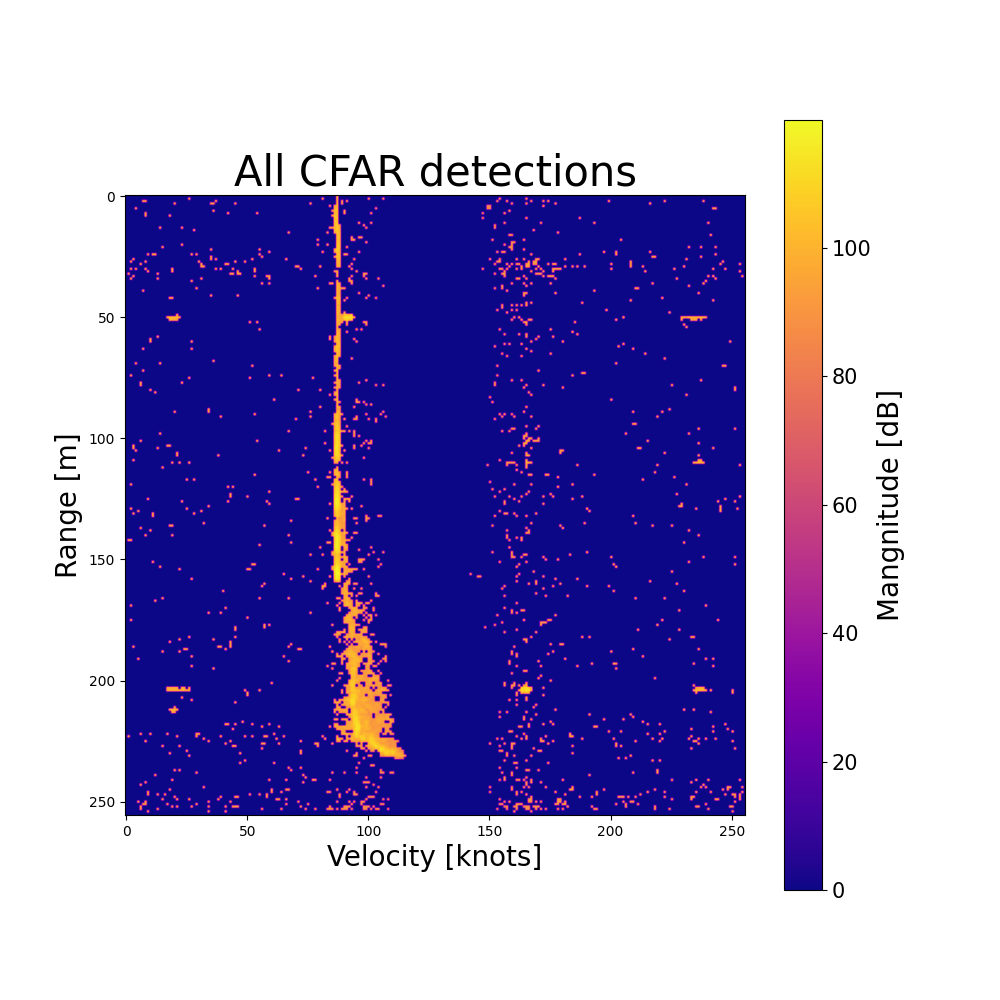

In [229]:
%matplotlib ipympl
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "All CFAR detections"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})

test = np.max(np.abs(cfar_array),axis=0)
plt.figure(figsize=(10,10))
print(np.shape(test))
#test[test>40] =0

rotated_img =20*np.log10(np.abs(test)) # We rotate the image so the x axis is the velocity
#rotated_img = ndimage.rotate(rotated_img,90)
#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
#plt.imshow(rotated_img,cmap="plasma", vmin=plot_min_doppler,vmax=plot_max_doppler)
plt.imshow(rotated_img,cmap="plasma",vmin=0)
# rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
# peak = 10*np.log(np.abs(rotated_img[137,87]))
# snr = peak-rms
# print("Peak:",peak)
# print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
# print("RMS:",rms)
# print("SNR:",snr) 
#plt.xlim(80,94)
#plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)



#plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)
#plt.savefig("plots/munkholm/cfar_EMA_0_MTI_munkholm_with_window.svg",format="svg")

29.112477128081473
29.112477128081473


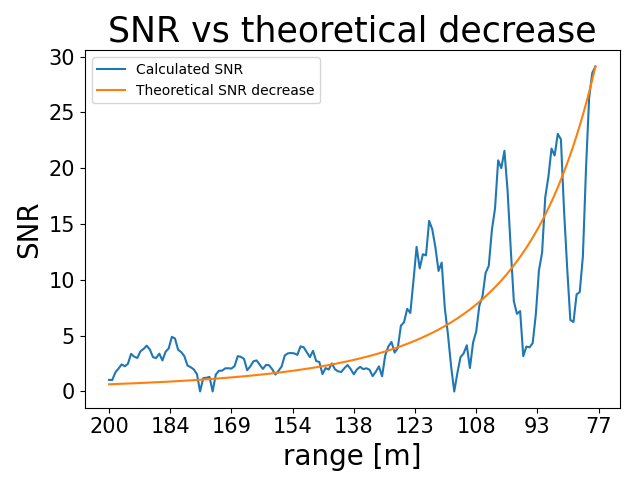

In [230]:
plt.figure()
start_bin =1
end_bin = 157

detections =np.max(np.abs(SNR_D_array),axis=0)
#detections = ndimage.rotate(detections,90)
detection_line = np.abs(np.max(detections[start_bin:end_bin,86:88],axis=1))
#detection_line = np.abs(detections[start_bin:end_bin,87])

r = np.linspace((255-start_bin)*0.785277,(255-end_bin)*0.785277,len(detection_line))
print(max(detection_line))
r_squared =max(detection_line)/(r/((255-end_bin)*0.785277))**4
print(max(detection_line))
plt.plot(detection_line,label="Calculated SNR")

plt.plot(r_squared,label="Theoretical SNR decrease")

plt.legend()
plt.title("SNR vs theoretical decrease",size=25)
#plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("range [m]",size=20)
plt.ylabel("SNR",size=20)
plt.tight_layout()
plt.xticks(np.linspace(0,len(detection_line),9),labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,9)),size =15)
#plt.savefig("plots/results/SNR_vs_decrese_mean.svg",format="svg")
plt.show()

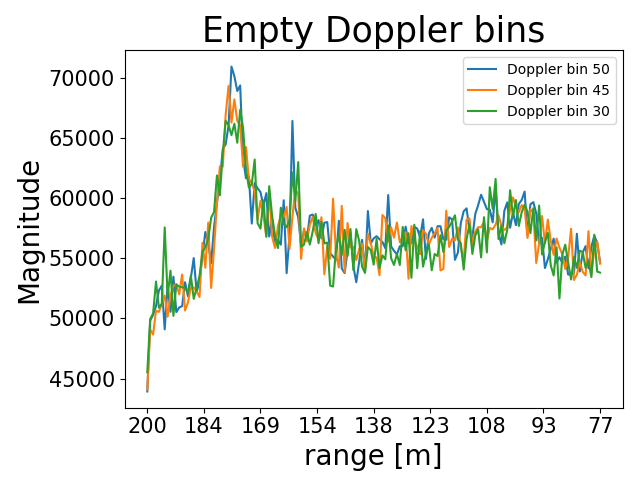

In [87]:
plt.figure()
detections =np.mean(np.abs(raw_t[100:500]),axis=0)
detections = ndimage.rotate(detections,90)
detection_line = np.abs(detections[:157,50])



plt.plot(np.abs(detections[:157,50]),label="Doppler bin 50")
plt.plot(np.abs(detections[:157,45]),label="Doppler bin 45")
plt.plot(np.abs(detections[:157,30]),label="Doppler bin 30")



plt.legend()
plt.title("Empty Doppler bins",size=25)
#plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("range [m]",size=20)
plt.ylabel("Magnitude",size=20)
plt.tight_layout()
plt.xticks(np.linspace(0,156,9),labels=np.int16(np.linspace(200,(255-156)*0.785277,9)),size =15)
plt.savefig("plots/noisefor_problem.svg",format="svg")
plt.show()

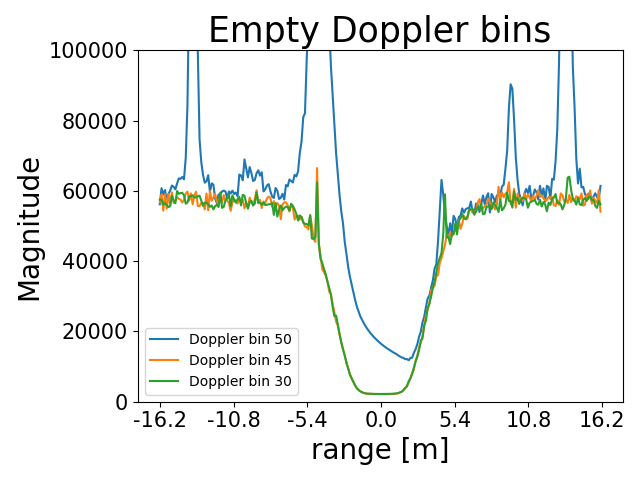

In [88]:
plt.figure()
detections =np.mean(np.abs(raw_t[100:500]),axis=0)
detections = ndimage.rotate(detections,90)
detection_line = np.abs(detections[50,])



plt.plot(np.abs(detections[50,:]),label="Doppler bin 50")
plt.plot(np.abs(detections[55,:]),label="Doppler bin 45")
plt.plot(np.abs(detections[45,:]),label="Doppler bin 30")



plt.legend()
plt.title("Empty Doppler bins",size=25)
plt.ylim(0,100000)
plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("range [m]",size=20)
plt.ylabel("Magnitude",size=20)
plt.tight_layout()
#plt.xticks(np.linspace(0,len(detections[50,:]),9),labels=np.int16(np.linspace(200,len(detections[50,:])*0.785277,9)),size =15)
#plt.savefig("plots/noisefor_problem.svg",format="svg")
plt.show()

694258.4059221797
694258.4059221797


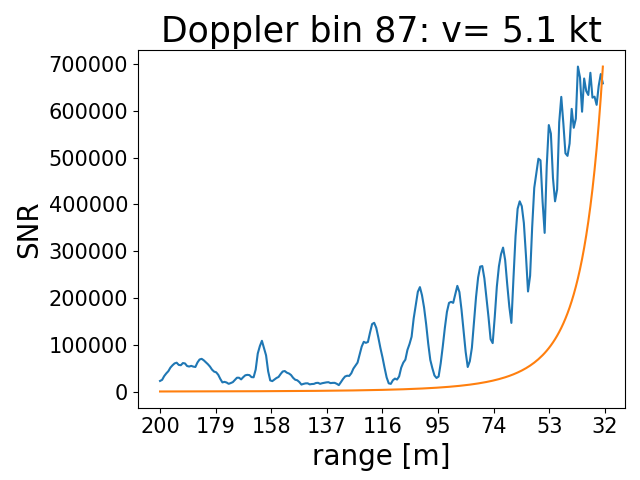

In [89]:
plt.figure()
start_bin =1
end_bin = 215

detections =np.max(np.abs(data_diff),axis=0)
detections = ndimage.rotate(detections,90)
detection_line = np.abs(np.max(detections[start_bin:end_bin,86:108],axis=1))

r = np.linspace((255-start_bin)*0.785277,(255-end_bin)*0.785277,len(detection_line))
print(max(detection_line))
r_squared =max(detection_line)/(r/((255-end_bin)*0.785277))**4
print(max(detection_line))
plt.plot(detection_line,label="Calculated SNR")

plt.plot(r_squared,label="Theoretical SNR decrease")

#plt.legend()
plt.title("Doppler bin 87: v= 5.1 kt",size=25)
#plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("range [m]",size=20)
plt.ylabel("SNR",size=20)
plt.tight_layout()
plt.xticks(np.linspace(0,len(detection_line),9),labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,9)),size =15)
#plt.savefig("plots/noisefor_problem.svg",format="svg")
plt.show()

In [166]:
data_diff_0 = data_diff.copy()

3665316.809812145
3665316.809812145


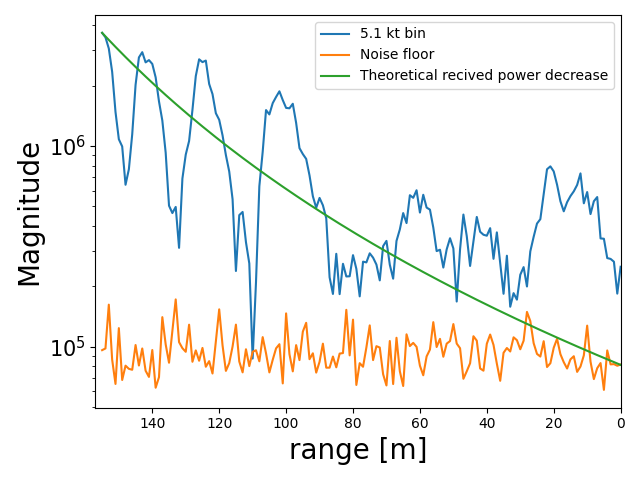

In [254]:
plt.figure()
start_bin =1
end_bin = 157

detections =np.max(np.abs(data_diff),axis=0)
detections  = ndimage.rotate(detections,90)
detection_line = np.abs(np.max(detections[start_bin:end_bin,86:88],axis=1))

#detections_2 =np.max(np.abs(data_diff_0),axis=0)
#detections_2  = ndimage.rotate(detections_2,90)
#detection_line_2 = np.abs(np.max(detections_2[start_bin:end_bin,50:53],axis=1))
#detection_line = np.abs(detections[start_bin:end_bin,87])

r = np.linspace((255-start_bin)*0.785277,(255-end_bin)*0.785277,len(detection_line))
print(max(detection_line))
r_squared =max(detection_line)/(r/((255-end_bin)*0.785277))**4
print(max(detection_line))
plt.semilogy(detection_line,label="5.1 kt bin")
#plt.plot(detection_line_2,label="before")
plt.semilogy(np.abs(detections[start_bin:end_bin,50]),label="Noise floor")
plt.semilogy(r_squared,label="Theoretical recived power decrease")

plt.legend()
#plt.title("Range-Doppler map",size=25)
#plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("range [m]",size=20)
plt.ylabel("Magnitude",size=20)
plt.xlim(157,0)
plt.tight_layout()
#plt.xticks(np.linspace(0,len(detection_line),9),labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,9)),size =15)
plt.savefig("plots/results/recived_power_falloff_logy.png")
plt.show()

# MEDIAN

In [90]:
def P_avg(P,N):
    return P/N
def alpha(N,P_FA):
    return N*(P_FA**(-1/N)-1)

def estimated_teshold(alpha,P):
    return alpha*np.abs(P)
def window_estimator(x,training_cells,training_area):    
    
    P_total = np.sum(np.abs(x))
    P_center_square =np.sum(np.abs(x[training_cells:x.shape[0]-training_cells,training_cells:x.shape[1]-training_cells]))
    P_traning_cells = np.abs(P_total - P_center_square)
    
    return P_avg(P_total,training_area)

def CFAR_2D_Median(data, guard_cells, training_cells, PFA,plot = False,iso_axis =False,saveFig=False,filename =""):
    """_summary_

    Args:
        data (_type_): _description_
        guard_cells (_type_): _description_
        training_cells (_type_): _description_
        threshold (_type_): _description_
    """
    idx_peaks = []
    treshold_map = np.zeros(data.shape)

    window_size = guard_cells + training_cells
    data = ndimage.rotate(data, 90)
    
    data_cfar = np.pad(data, window_size, mode='edge')
    

    window_area = (2*window_size+1)**2
    training_area = window_area - (2*window_size+1-2*training_cells)**2
    print("traning area",training_area)
    a = alpha(training_area, PFA)
    detections = []

    for i in range(256):
        for j in range(256):
            P_training = window_estimator(data_cfar[i:i+2*window_size+1,j:j+2*window_size+1],training_cells ,training_area)
            threshold = estimated_teshold(a,P_training)
            treshold_map[i,j] = threshold
            
            if(np.abs(data[i,j]) < threshold):
                data[i,j] = 1
            else:
                idx_peaks.append([i,j])
                detections.append({
                    "cords":(i,j),
                    "peak":np.abs(data[i,j]),
                    "noise_est":np.abs(P_training),
                    "SNR":10*np.log10(np.abs(data[i,j])/np.abs(P_training))
                    }
                 )
                
    
    if(plot):
        newlist = sorted(detections, key=itemgetter("SNR"),reverse=True)
        print("Total detections",len(newlist))
        for i in newlist:
            print(i,"\n")
        plt.figure(figsize=(20,15))
        #rotated_img = ndimage.rotate(np.abs(data),90) # We rotate the image so the x axis is the velocity
        rotated_img =20*np.log10(np.abs(data))
        plt.imshow(rotated_img,cmap="plasma")
        plt.grid(False)
        if(iso_axis):
            plt.yticks(np.linspace(0,256,9),labels=np.linspace(200,0,9))
        
            plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-16.1987,16.1987,7),2))
        cbar  = plt.colorbar()
        cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
        plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
        plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
        plt.title("CFAR",fontdict = {'fontsize' : 30})
        if saveFig:
            plt.savefig(f'plots/{filename}.svg',format="svg")
        plt.show()

        
    
    
    
            
    return data, detections, treshold_map

In [91]:
cfar_median= []
#SNR_array = []
#SNR_D_array = []
length_data_diff = len(data_diff[100:500])
for i,img in enumerate( data_diff[100:500]):
    cfar ,y,SNR = CFAR_2D_Median(img,5, 10, 0.000001,plot=False, iso_axis=True)
    cfar_median.append(cfar)
    #SNR_array.append(SNR)
    #SNR_D_array.append(y)
    print(np.round(i/length_data_diff*100,1))

traning area 840
0.0
traning area 840
0.2
traning area 840
0.5
traning area 840
0.8
traning area 840
1.0
traning area 840
1.2
traning area 840
1.5
traning area 840
1.8
traning area 840
2.0
traning area 840
2.2
traning area 840
2.5
traning area 840
2.8
traning area 840
3.0
traning area 840
3.2
traning area 840
3.5
traning area 840
3.8
traning area 840
4.0
traning area 840
4.2
traning area 840
4.5
traning area 840
4.8
traning area 840
5.0
traning area 840
5.2
traning area 840
5.5
traning area 840
5.8
traning area 840
6.0
traning area 840
6.2
traning area 840
6.5
traning area 840
6.8
traning area 840
7.0
traning area 840
7.2
traning area 840
7.5
traning area 840
7.8
traning area 840
8.0
traning area 840
8.2
traning area 840
8.5
traning area 840
8.8
traning area 840
9.0
traning area 840
9.2
traning area 840
9.5
traning area 840
9.8
traning area 840
10.0
traning area 840
10.2
traning area 840
10.5
traning area 840
10.8
traning area 840
11.0
traning area 840
11.2
traning area 840
11.5
tranin

(256, 256)


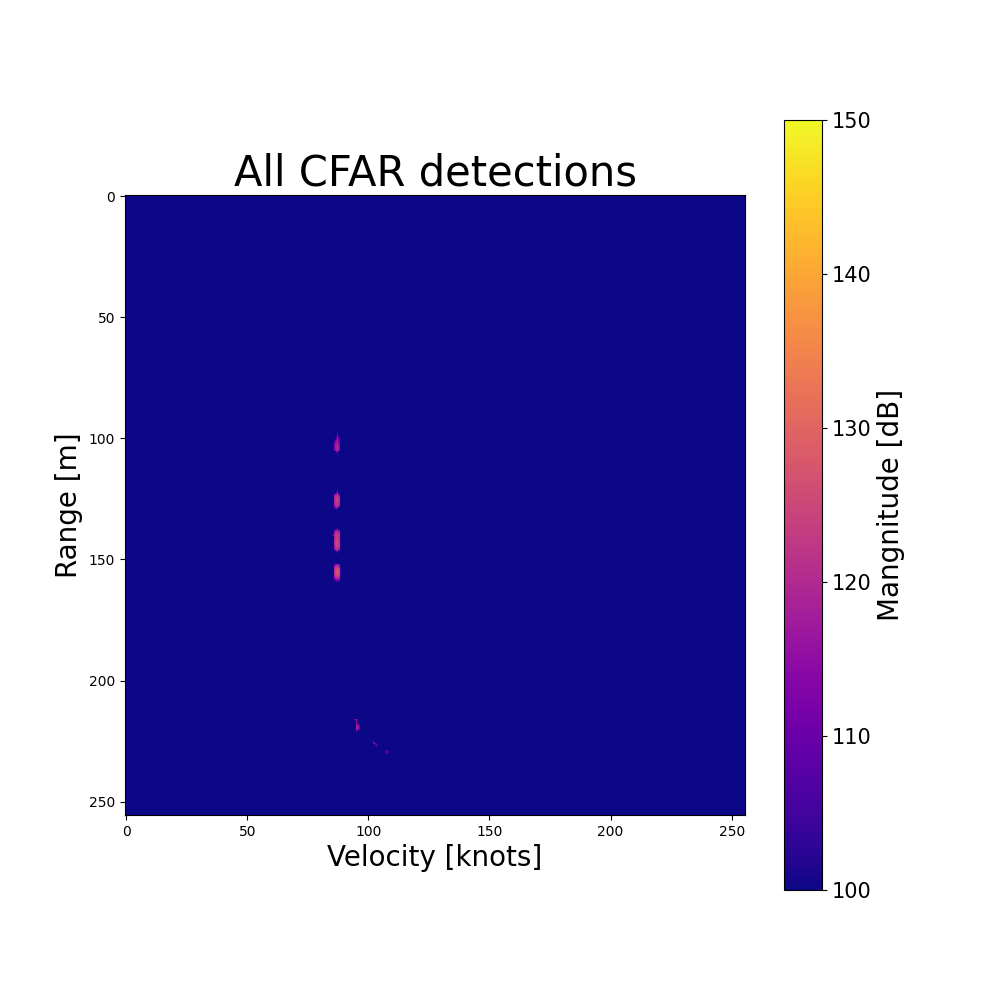

In [99]:
%matplotlib ipympl
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "All CFAR detections"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
test = np.sum(np.abs(cfar_median),axis=0)
plt.figure(figsize=(10,10))
print(np.shape(test))
rotated_img =20*np.log10(np.abs(test)) # We rotate the image so the x axis is the velocity
#rotated_img = test
#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
plt.imshow(rotated_img,cmap="plasma", vmin=plot_min_doppler,vmax=plot_max_doppler)
#plt.imshow(rotated_img,cmap="plasma")
# rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
# peak = 10*np.log(np.abs(rotated_img[137,87]))
# snr = peak-rms
# print("Peak:",peak)
# print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
# print("RMS:",rms)
# print("SNR:",snr) 
#plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)



#plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)
#plt.savefig("plots/munkholm/cfar_EMA_0_MTI_munkholm_with_window.svg",format="svg")

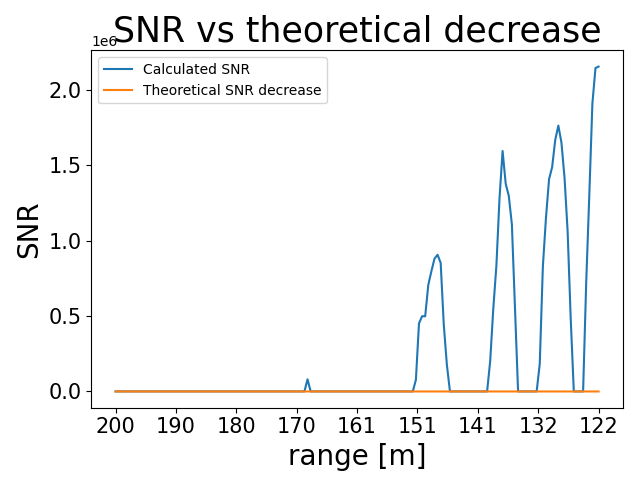

In [93]:
plt.figure()
detections = np.sum(np.abs(cfar_median),axis=0)

detection_line = np.abs(detections[:157,87])

r = np.linspace(200,122,157)
r_squared =75/(r/122)**4

plt.plot(detection_line,label="Calculated SNR")

plt.plot(r_squared,label="Theoretical SNR decrease")

plt.legend()
plt.title("SNR vs theoretical decrease",size=25)
#plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("range [m]",size=20)
plt.ylabel("SNR",size=20)
plt.tight_layout()
plt.xticks(np.linspace(0,156,9),labels=np.int16(np.linspace(200,156*0.785277,9)),size =15)
#plt.savefig("plots/SNR_vs_falloff.svg",format="svg")
plt.show()

# IO

In [94]:
cfar_IO= []
#SNR_array = []
#SNR_D_array = []
length_data_diff = len(data_diff[100:500])
for i,img in enumerate( data_diff[100:500]):
    cfar ,y,SNR = utils.CFAR_IO(img,10, 15, 0.000001,plot=False, iso_axis=True)
    cfar_IO.append(cfar)
    #SNR_array.append(SNR)
    #SNR_D_array.append(y)
    print(np.round(i/length_data_diff*100,1))

traning area 2160
0.0
traning area 2160
0.2
traning area 2160
0.5
traning area 2160
0.8
traning area 2160
1.0
traning area 2160
1.2
traning area 2160
1.5
traning area 2160
1.8
traning area 2160
2.0
traning area 2160
2.2
traning area 2160
2.5
traning area 2160
2.8
traning area 2160
3.0
traning area 2160
3.2
traning area 2160
3.5
traning area 2160
3.8
traning area 2160
4.0
traning area 2160
4.2
traning area 2160
4.5
traning area 2160
4.8
traning area 2160
5.0
traning area 2160
5.2
traning area 2160
5.5
traning area 2160
5.8
traning area 2160
6.0
traning area 2160
6.2
traning area 2160
6.5
traning area 2160
6.8
traning area 2160
7.0
traning area 2160
7.2
traning area 2160
7.5
traning area 2160
7.8
traning area 2160
8.0
traning area 2160
8.2
traning area 2160
8.5
traning area 2160
8.8
traning area 2160
9.0
traning area 2160
9.2
traning area 2160
9.5
traning area 2160
9.8
traning area 2160
10.0
traning area 2160
10.2
traning area 2160
10.5
traning area 2160
10.8
traning area 2160
11.0
trani

(256, 256)


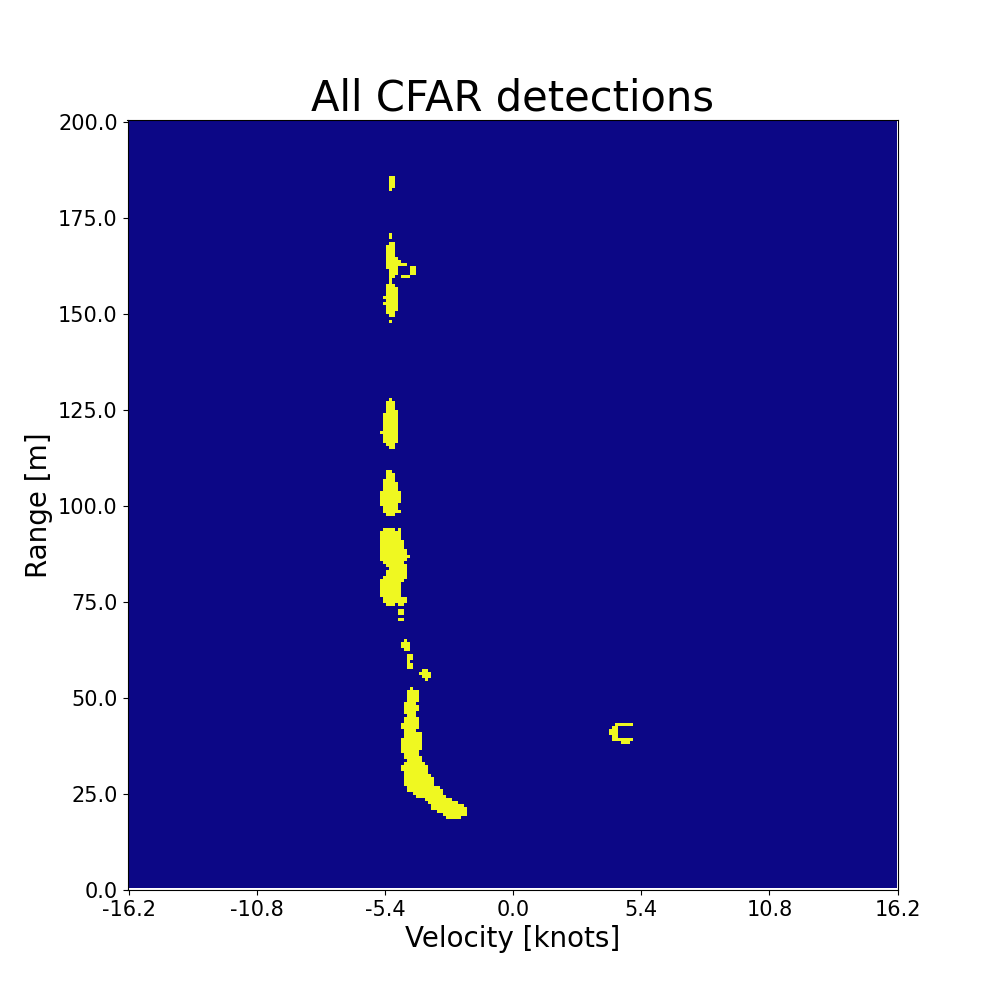

In [95]:
%matplotlib ipympl
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "All CFAR detections"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
test = np.sum(np.abs(cfar_IO),axis=0)
test[test>0]=1
plt.figure(figsize=(10,10))
print(np.shape(test))
rotated_img =np.abs(test) # We rotate the image so the x axis is the velocity
#rotated_img = test
#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
#plt.imshow(rotated_img,cmap="plasma", vmin=-10,vmax=50)
plt.imshow(rotated_img,cmap="plasma")
# rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
# peak = 10*np.log(np.abs(rotated_img[137,87]))
# snr = peak-rms
# print("Peak:",peak)
# print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
# print("RMS:",rms)
# print("SNR:",snr) 
plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)



plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)

plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)
plt.savefig("plots/elfryd_IO.svg",format="svg")
